In [1]:
import numpy as np

import pandas as pd

import xarray as xr

from affine import Affine

import matplotlib.pyplot as plt

import rasterio 

from rasterio.plot import show

from glob import glob

import rioxarray

In [2]:
from scipy import stats
import dask.array as da
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from statsmodels.graphics.gofplots import qqplot_2samples


In [3]:
# start a Dask client
from dask.distributed import Client

client = Client()
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.72 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61338,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.72 GiB
Comm: tcp://127.0.0.1:61363,Total threads: 3
Dashboard: http://127.0.0.1:61365/status,Memory: 7.93 GiB
Nanny: tcp://127.0.0.1:61341,


In [96]:
# Path of the folder containing the terrain .tiff files
IMG_PATH = 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/terrain/Terrain_Addison_M03.tif'

terrain = rioxarray.open_rasterio(IMG_PATH, chunks = (1,128,128), masked = True)

#slice xds - may need to compute 
terrain = terrain[:,2609,3444]

# Stack bands into a single DataArray
terrain

<xarray.DataArray (band: 1)>
dask.array<getitem, shape=(1,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
    x            float64 1.098e+06
    y            float64 1.916e+06
    spatial_ref  int32 0
Attributes: (12/19)
    AREA_OR_POINT:             Area
    HISTOGRAM:                 42941|1342|609|551|466|413|411|518|461|500|424...
    TIFFTAG_ARTIST:            HEC-RAS
    TIFFTAG_IMAGEDESCRIPTION:  Terrain Raster
    TIFFTAG_SOFTWARE:          HEC-RAS
    DECIMAL_PRECISION:         ThirtySeconds
    ...                        ...
    STATISTICS_SKIPFACTORY:    1
    STATISTICS_STDDEV:         26.292600539339
    TYPE:                      Elevation
    UNITS:                     Feet
    scale_factor:              1.0
    add_offset:                0.0

In [97]:
# Path of the folder containing the .tiff files
IMG_PATH = 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/wsel_grids/'

# List of .tiff files
wse_layers = glob(f"{IMG_PATH}*.tif")
wse_layers.sort() # sorted list
        
ls_wse_layers = [] # list filled with the first layer of each file
for l in wse_layers:
    xds = rioxarray.open_rasterio(l, chunks = (1,128,128), masked = True)
    #slice xds - may need to compute 
    xds = xds[:,2609,3444]
    ls_wse_layers.append(xds-terrain) # index 0 corresponds to the first band of each file

# Stack bands into a single DataArray
print(type(ls_wse_layers[0]))

# change the lib to rioxarray-rasterio
# chunk parameter 128*128
# ***check xds shape 

<class 'xarray.core.dataarray.DataArray'>


In [98]:
ds = ls_wse_layers[0].to_dataset(name = "wse1")

idx = 1
for i in range(idx,len(ls_wse_layers)):
    var_name = "wse"+ str(i+1)
    ds[var_name] = ls_wse_layers[i]
    
ds

<xarray.Dataset>
Dimensions:      (band: 1)
Coordinates:
  * band         (band) int32 1
    x            float64 1.098e+06
    y            float64 1.916e+06
    spatial_ref  int32 0
Data variables: (12/96)
    wse1         (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wse2         (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wse3         (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wse4         (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wse5         (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wse6         (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...           ...
    wse91        (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wse92        (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wse93        (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wse94        (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wse95        (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wse96        (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [99]:
index_list = range(1, 97)

ds = xr.concat(
    [ds[f"wse{i}"] for i in range(1, len(index_list) + 1)],
    dim=pd.Index(index_list, name="scenario"),
).to_dataset(name="all_runs")


In [100]:
ds['all_runs']

<xarray.DataArray 'all_runs' (scenario: 96, band: 1)>
dask.array<concatenate, shape=(96, 1), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
    x            float64 1.098e+06
    y            float64 1.916e+06
    spatial_ref  int32 0
  * scenario     (scenario) int64 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96

In [101]:
#ds = ds.drop_vars('scenario')
#ds_test = ds.sel(scenario = 1)
ds_test = ds.sel(band = 1)

In [102]:
ds_test

<xarray.Dataset>
Dimensions:      (scenario: 96)
Coordinates:
    band         int32 1
    x            float64 1.098e+06
    y            float64 1.916e+06
    spatial_ref  int32 0
  * scenario     (scenario) int64 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
Data variables:
    all_runs     (scenario) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [103]:
da_test = ds_test.to_array() 
da_test = da_test.sel(variable = 'all_runs')
da_test = np.nan_to_num(da_test,nan = 0.000001)
da_test

array([6.07299805e-01, 1.42395020e-01, 9.99999997e-07, 6.62048340e-01,
       5.66162109e-01, 2.59399414e-02, 9.99999997e-07, 9.34326172e-01,
       1.17083740e+00, 1.32153320e+00, 7.74963379e-01, 1.37963867e+00,
       1.17968750e+00, 1.09301758e+00, 6.82617188e-01, 1.23016357e+00,
       1.64086914e+00, 1.40985107e+00, 1.55163574e+00, 1.91595459e+00,
       1.66882324e+00, 1.76513672e+00, 1.44610596e+00, 1.78601074e+00,
       2.67395020e+00, 1.99285889e+00, 1.76007080e+00, 2.66998291e+00,
       2.77801514e+00, 1.88037109e+00, 1.64562988e+00, 2.38842773e+00,
       3.78875732e+00, 2.44238281e+00, 2.21130371e+00, 3.34191895e+00,
       3.85992432e+00, 2.27441406e+00, 2.15991211e+00, 2.95422363e+00,
       4.74749756e+00, 2.85064697e+00, 2.60266113e+00, 3.76373291e+00,
       4.69195557e+00, 3.12304688e+00, 2.80224609e+00, 4.25250244e+00,
       5.96087646e+00, 3.67437744e+00, 3.31146240e+00, 4.77819824e+00,
       5.94439697e+00, 4.09918213e+00, 3.67626953e+00, 5.42919922e+00,
      

###### print(da_test.shape)
print(type(da_test))

In [104]:
da_test = ds_test.to_array() 
da_test = da_test.sel(variable = 'all_runs')
da_test = np.nan_to_num(da_test,nan = np.mean(da_test))
da_test

array([ 0.6072998 ,  0.14239502,  5.311001  ,  0.66204834,  0.5661621 ,
        0.02593994,  5.311001  ,  0.9343262 ,  1.1708374 ,  1.3215332 ,
        0.7749634 ,  1.3796387 ,  1.1796875 ,  1.0930176 ,  0.6826172 ,
        1.2301636 ,  1.6408691 ,  1.4098511 ,  1.5516357 ,  1.9159546 ,
        1.6688232 ,  1.7651367 ,  1.446106  ,  1.7860107 ,  2.6739502 ,
        1.9928589 ,  1.7600708 ,  2.669983  ,  2.7780151 ,  1.8803711 ,
        1.6456299 ,  2.3884277 ,  3.7887573 ,  2.4423828 ,  2.2113037 ,
        3.341919  ,  3.8599243 ,  2.274414  ,  2.159912  ,  2.9542236 ,
        4.7474976 ,  2.850647  ,  2.6026611 ,  3.763733  ,  4.6919556 ,
        3.1230469 ,  2.802246  ,  4.2525024 ,  5.9608765 ,  3.6743774 ,
        3.3114624 ,  4.7781982 ,  5.944397  ,  4.099182  ,  3.6762695 ,
        5.429199  ,  7.753662  ,  4.996826  ,  4.61615   ,  6.929138  ,
        7.709839  ,  5.42572   ,  4.814575  ,  7.490906  ,  8.954956  ,
        7.2507935 ,  6.8308716 ,  8.38501   ,  8.91803   ,  7.42

In [105]:
da_test = ds_test.to_array() 
da_test = da_test.sel(variable = 'all_runs')
da_test = np.nan_to_num(da_test,nan = 0)
da_test

array([ 0.6072998 ,  0.14239502,  0.        ,  0.66204834,  0.5661621 ,
        0.02593994,  0.        ,  0.9343262 ,  1.1708374 ,  1.3215332 ,
        0.7749634 ,  1.3796387 ,  1.1796875 ,  1.0930176 ,  0.6826172 ,
        1.2301636 ,  1.6408691 ,  1.4098511 ,  1.5516357 ,  1.9159546 ,
        1.6688232 ,  1.7651367 ,  1.446106  ,  1.7860107 ,  2.6739502 ,
        1.9928589 ,  1.7600708 ,  2.669983  ,  2.7780151 ,  1.8803711 ,
        1.6456299 ,  2.3884277 ,  3.7887573 ,  2.4423828 ,  2.2113037 ,
        3.341919  ,  3.8599243 ,  2.274414  ,  2.159912  ,  2.9542236 ,
        4.7474976 ,  2.850647  ,  2.6026611 ,  3.763733  ,  4.6919556 ,
        3.1230469 ,  2.802246  ,  4.2525024 ,  5.9608765 ,  3.6743774 ,
        3.3114624 ,  4.7781982 ,  5.944397  ,  4.099182  ,  3.6762695 ,
        5.429199  ,  7.753662  ,  4.996826  ,  4.61615   ,  6.929138  ,
        7.709839  ,  5.42572   ,  4.814575  ,  7.490906  ,  8.954956  ,
        7.2507935 ,  6.8308716 ,  8.38501   ,  8.91803   ,  7.42

In [106]:
import json
  
# Opening JSON file
f = open('C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/Addison_M03_H04_Weights.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
  
# Closing file
f.close()

In [107]:
weights = list(data.values()) # we don't need to query weights based on file names here due to the sorting Python / whoever prepared the data; future efforts may be needed to add code for dict query 
weights = np.array(weights)
print(type(weights))

<class 'numpy.ndarray'>


In [108]:
count = np.round(weights*10**5)
count = np.int_(count)

In [109]:
full_values = np.repeat(da_test, count)
full_values

array([ 0.6072998,  0.6072998,  0.6072998, ..., 11.103638 , 12.029175 ,
       12.029175 ], dtype=float32)

In [110]:
pct_zero = np.count_nonzero(full_values == 0)/len(full_values)
pct_zero

0.15928110506150434

In [111]:
pct_nonzero = np.count_nonzero(full_values != 0)/len(full_values)
pct_nonzero

0.8407188949384957

In [112]:
depth_nonzero = full_values[full_values != 0]


In [113]:
pct_zero = np.count_nonzero(da_test == 0)/len(da_test)
pct_nonzero = np.count_nonzero(da_test!=0)/len(da_test)
pct_zero

0.020833333333333332

(array([9.52874667e-01, 3.05492769e-01, 2.48592877e-01, 4.90249134e-02,
        2.58283613e-02, 7.67098251e-03, 1.52603588e-02, 4.40673293e-03,
        1.42810900e-03, 3.95789902e-03, 0.00000000e+00, 7.95660727e-04,
        1.20369187e-03, 1.63212331e-04, 8.77266279e-04, 1.42810790e-04,
        3.26424662e-04, 1.83614156e-04, 2.24416955e-04, 2.85621579e-04]),
 array([ 0.        ,  0.61776429,  1.23552859,  1.85329282,  2.47105718,
         3.08882141,  3.70658565,  4.32434988,  4.94211435,  5.55987835,
         6.17764282,  6.7954073 ,  7.41317129,  8.03093529,  8.64869976,
         9.26646423,  9.88422871, 10.50199318, 11.1197567 , 11.73752117,
        12.35528564]),
 <BarContainer object of 20 artists>)

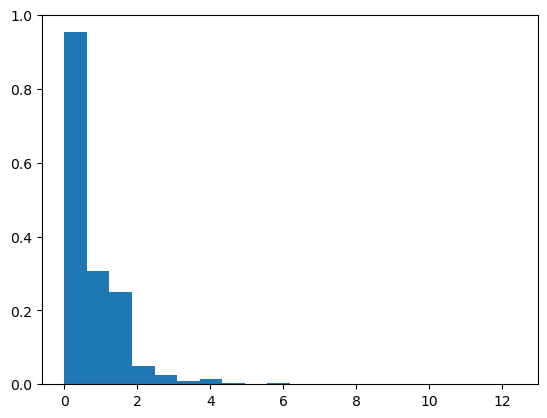

In [114]:
plt.hist(full_values, density = True, bins = 20)

# Gumbel Distribution

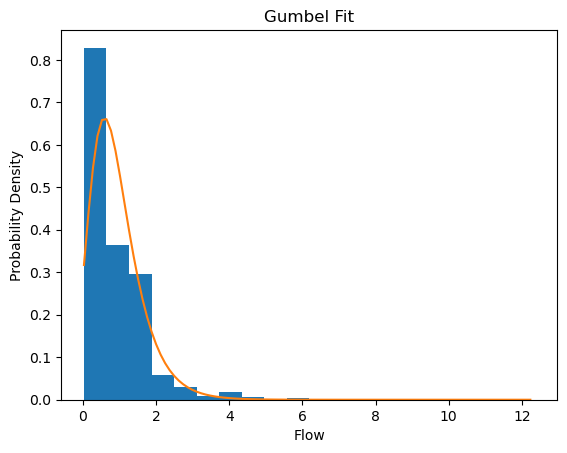

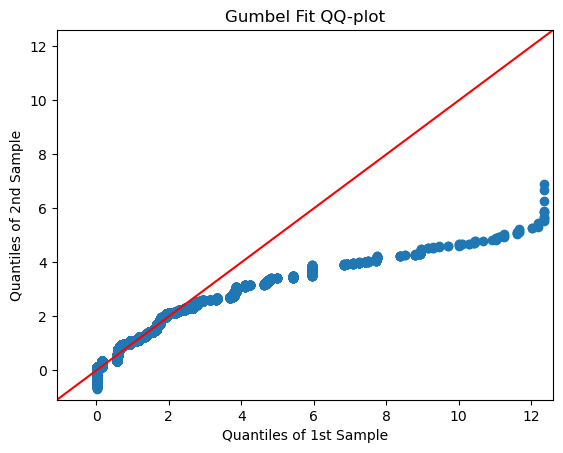

In [115]:
def fit_gumbel(data: np.ndarray):
    loc, scale = stats.gumbel_r.fit(data)
    plt.hist(data, density=True, bins = 20)
    x = np.arange(np.min(data), np.max(data), (-np.min(data) + np.max(data))/100)
    f_x = stats.gumbel_r.pdf(x, loc, scale)
    plt.plot(x, f_x)
    plt.title("Gumbel Fit")    
    plt.xlabel("Flow")
    plt.ylabel("Probability Density")
    plt.show()
    
    estimate = np.random.gumbel(loc,scale,size = len(data))
    pp_x = sm.ProbPlot(data)
    pp_y = sm.ProbPlot(estimate)
    qqplot_2samples(pp_x, pp_y,line='45')
    plt.title("Gumbel Fit QQ-plot")
    plt.show()
    
fit_gumbel(depth_nonzero)    

# Weibull Distribution

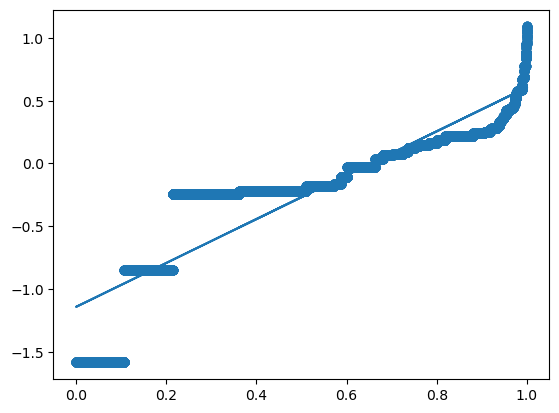

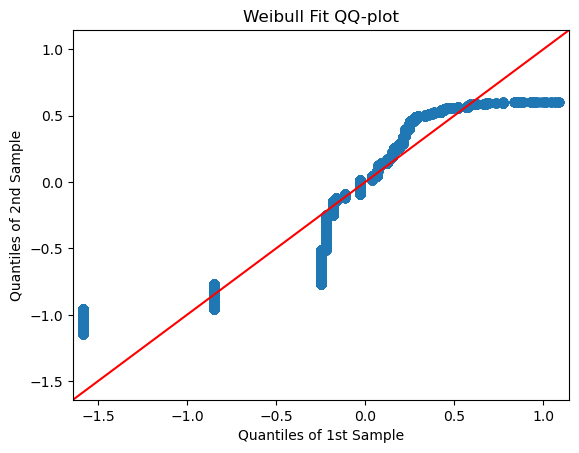

In [116]:
def weibull_fit(data: np.ndarray):
    # if np.isnan(data).any():
    #     return (np.nan, np.nan)
    ranks = data.argsort().argsort()+1
    probs = ranks/(len(ranks)+1)
    slope, intercept = np.polyfit(probs, np.log10(data), 1)
    x = np.linspace(probs.min(), probs.max(), 100)
    plt.scatter(probs, np.log10(data))
    plt.plot(probs, slope*probs+intercept) 
    #plt.plot(x, 10**(slope*x+intercept))
    plt.show()
    
    estimate = slope*probs+intercept
    pp_x = sm.ProbPlot(np.log10(data))
    pp_y = sm.ProbPlot(estimate)
    qqplot_2samples(pp_x, pp_y,line='45')
    plt.title("Weibull Fit QQ-plot")
    plt.show()
    


weibull_fit(depth_nonzero)

# Pearson III

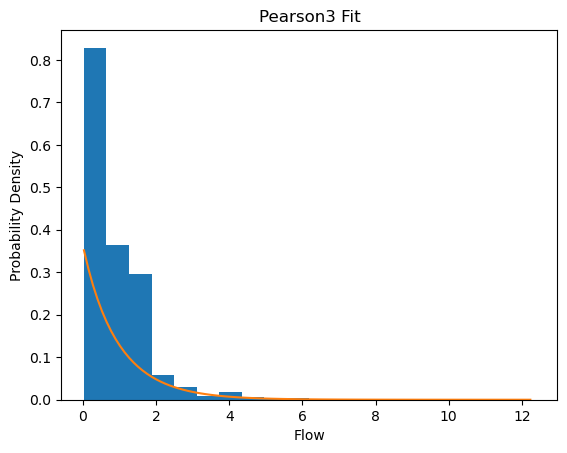

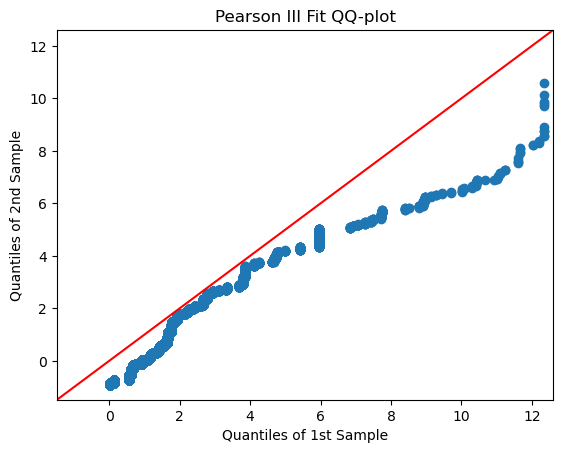

In [117]:
def pearson3_fit(data: np.ndarray):
    plt.hist(data, density = True, bins = 20)

    skew,loc,scale = stats.pearson3.fit(data)
    x = np.arange(np.min(data), np.max(data), (-np.min(data) + np.max(data))/100)
    f_x = stats.pearson3.pdf(x, skew)
    plt.plot(x, f_x)
    plt.title("Pearson3 Fit")    
    plt.xlabel("Flow")
    plt.ylabel("Probability Density")
    plt.show()
    
    estimate = stats.pearson3.rvs(skew, size=len(data))
    pp_x = sm.ProbPlot(data)
    pp_y = sm.ProbPlot(estimate)
    qqplot_2samples(pp_x, pp_y,line='45')
    plt.title("Pearson III Fit QQ-plot")
    plt.show()
    
pearson3_fit(depth_nonzero)

# Log Pearson III

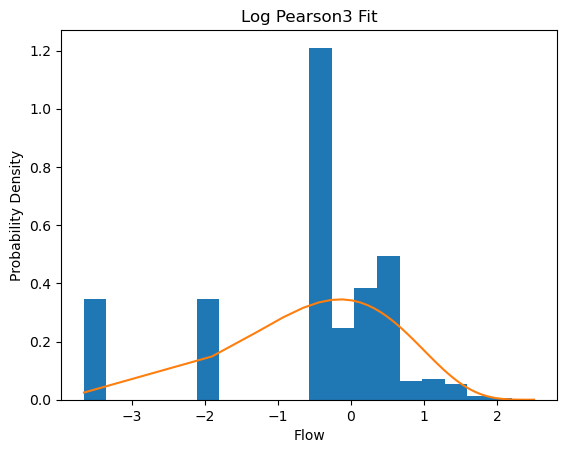

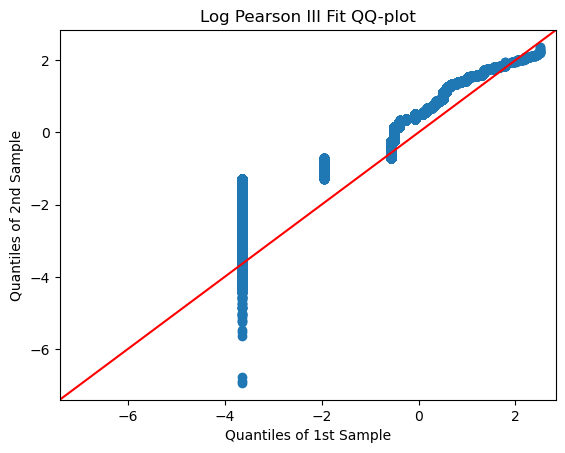

In [118]:
def fit_pearson3_log(data: np.ndarray):
    # Fit a log LP-III distribtion to a 1-dimensional NumPy array.
    # Returns fit parameters: (skew, loc, scale)
    # If any of the 1D array values are NaN, returns (None, None, None)
    data[data == 0] = np.nan
    if np.isnan(data).any():
        return (np.nan, np.nan, np.nan,np.nan)
    skew, loc, scale = stats.pearson3.fit(np.log(data))
    plt.hist(np.log(data), density = True, bins = 20)
    x = np.arange(np.min(data), np.max(data), (-np.min(data) + np.max(data))/100)
    f_x = stats.pearson3.pdf(np.log(x),skew, loc, scale)
    plt.plot(np.log(x), f_x)
    plt.title("Log Pearson3 Fit")    
    plt.xlabel("Flow")
    plt.ylabel("Probability Density")
    plt.show()
    
    estimate = stats.pearson3.rvs(skew, size=len(data))
    pp_x = sm.ProbPlot(np.log(data))
    pp_y = sm.ProbPlot(estimate)
    qqplot_2samples(pp_x, pp_y,line='45')
    plt.title("Log Pearson III Fit QQ-plot")
    plt.show()

fit_pearson3_log(depth_nonzero)

# GEV Distribution

In [119]:
from scipy.stats import genextreme as gev

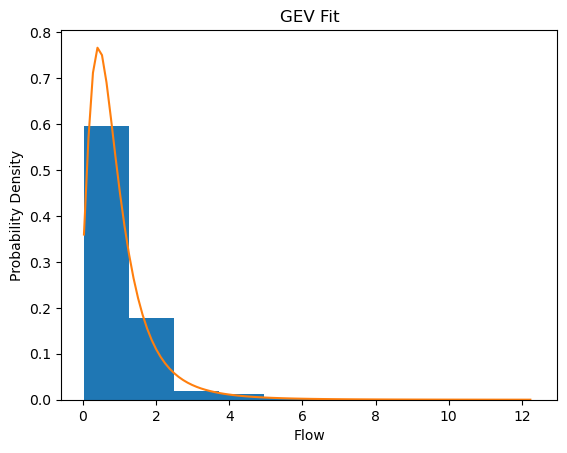

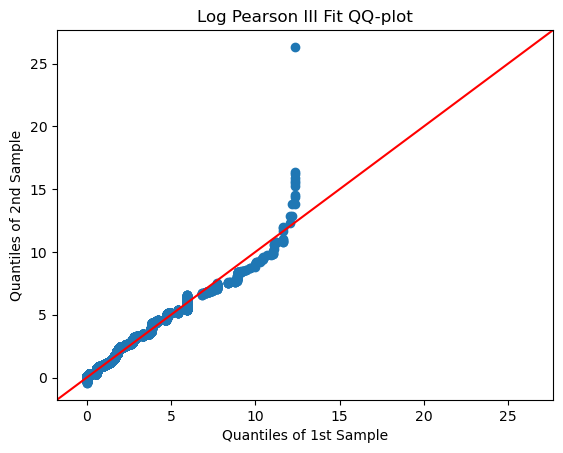

In [120]:
def GEV_fit(data: np.ndarray):
    shape, loc, scale = gev.fit(data)
    plt.hist(data, density = True)
    x = np.arange(np.min(data), np.max(data), (-np.min(data) + np.max(data))/100)
    f_x = gev.pdf(x,shape, loc, scale)
    plt.plot(x, f_x)
    plt.title("GEV Fit")    
    plt.xlabel("Flow")
    plt.ylabel("Probability Density")
    plt.show()
    
    estimate = gev.rvs(shape, loc, scale, size=len(data))
    pp_x = sm.ProbPlot(data)
    pp_y = sm.ProbPlot(estimate)
    qqplot_2samples(pp_x, pp_y,line='45')
    plt.title("Log Pearson III Fit QQ-plot")
    plt.show()
    
GEV_fit(depth_nonzero)

# Normal Distribution

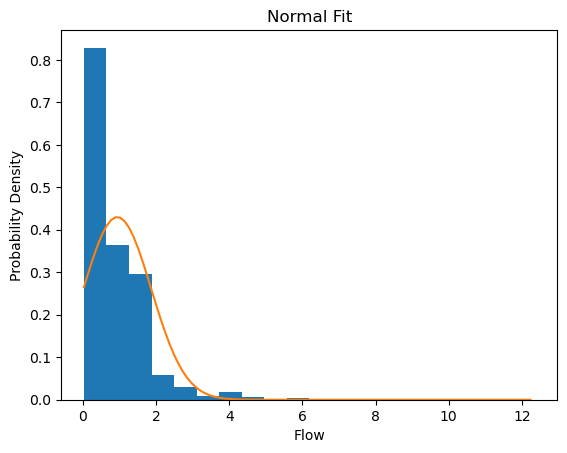

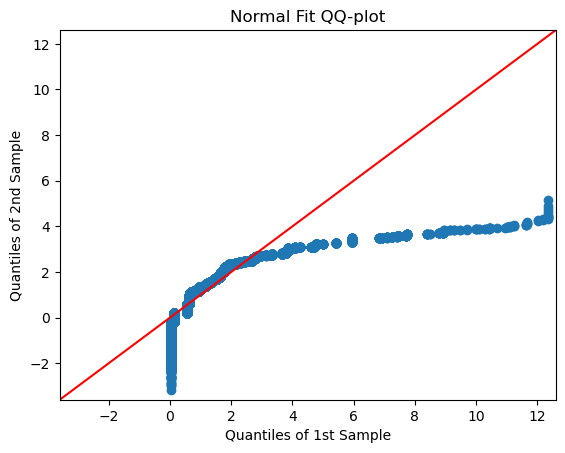

In [121]:
def fit_norm(data: np.ndarray):
    loc, scale = stats.norm.fit(data)
    plt.hist(data, density=True, bins = 20)
    x = np.arange(np.min(data), np.max(data), (-np.min(data) + np.max(data))/100)
    f_x = stats.norm.pdf(x, loc, scale)
    plt.plot(x, f_x)
    plt.title("Normal Fit")    
    plt.xlabel("Flow")
    plt.ylabel("Probability Density")
    plt.show()
    
    estimate = np.random.normal(loc,scale,size = len(data))
    pp_x = sm.ProbPlot(data)
    pp_y = sm.ProbPlot(estimate)
    qqplot_2samples(pp_x, pp_y,line='45')
    plt.title("Normal Fit QQ-plot")
    plt.show()
    
fit_norm(depth_nonzero)    

# Truncated and Hurdle Fit

In [168]:
# I still cannot get this snippet of code to work after re-establish Jupyter and statsmodel

# import statsmodels.discrete.truncated_model as smtc

# from statsmodels.discrete.discrete_model import (
#     Poisson, NegativeBinomial, NegativeBinomialP, GeneralizedPoisson)
# from statsmodels.discrete.count_model import (
#     ZeroInflatedPoisson,
#     ZeroInflatedGeneralizedPoisson,
#     ZeroInflatedNegativeBinomialP
#     )

# from statsmodels.discrete.truncated_model import (
#     TruncatedLFPoisson,
#     TruncatedLFNegativeBinomialP,
#     _RCensoredPoisson,
#     HurdleCountModel,
#     )

# Truncated and Hurdle Distribution using GEV

In [128]:
# Simulate different probability values 
aep_sim = np.random.rand(100)

In [165]:
def truncated_fit(depth_data: np.ndarray, aep: float) -> float:
    """ Calculate the flood depth percentile for a given AEP. """
    pct = 1- aep
    # Calculate the portion of non-zero values 
    prob_zero = np.sum(depth_data == 0) / depth_data.size
    depth_nonzero = depth_data[depth_data != 0]
    params = gev.fit(depth_nonzero) 
    if pct > prob_zero:
        pct_non_zero = (pct - prob_zero) / (1.0 - prob_zero) 
        non_zero_pct_depth = gev.ppf(pct_non_zero, *params) 
        return non_zero_pct_depth
    else:
        return 0

flood_truc_ls = []
for i in aep_sim:
    flood_simu = truncated_fit(full_values, i)
    flood_truc_ls.append(flood_simu)
        

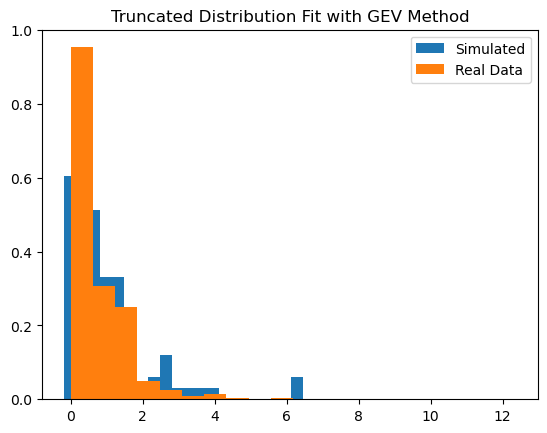

In [166]:
plt.hist(flood_truc_ls, density=True, bins = 20)
plt.hist(full_values, density = True, bins = 20)
plt.title("Truncated Distribution Fit with GEV Method")
plt.legend(["Simulated","Real Data"])
plt.show()

In [167]:
flood_truc_ls

[1.8148762160567826,
 0,
 0.893356991066842,
 2.626205461717475,
 0,
 0,
 1.6421837553130678,
 0.7815256268385702,
 0.49055644927931674,
 0.9819802317709279,
 0.2946656354844479,
 6.388566200490871,
 0.25546639681593886,
 0.5675637203472,
 1.31228657188352,
 2.6531422187655207,
 -0.004117001042557078,
 0.24117233754282708,
 0.8532670106574971,
 1.2278806532418316,
 1.4228870661072457,
 0.17867598729261713,
 1.398486766084914,
 0,
 0.5349125573476149,
 0,
 0.281090835011814,
 0.9276917985602842,
 1.2403465463685182,
 1.2165586723092403,
 0,
 0.7708736720646279,
 0.2666543595153456,
 0.41313987942312846,
 2.535673686176221,
 1.0267143141824708,
 0.6824049156643672,
 0.5235239690901962,
 0.8214312577381231,
 1.252687716574492,
 0.793247386407193,
 1.3439231205283506,
 0,
 0,
 0,
 0.28186494316580385,
 0.4517548408673875,
 0.20867537929707564,
 0.7484334740415712,
 0.2075891852983146,
 -0.15956385075656143,
 0.4130403748809818,
 6.446962788529831,
 0.2935527677433879,
 0.5991132431175176,


In [163]:
def hurdle_fit(depth_data: np.ndarray, aep: float) -> float:
    """ Calculate the flood depth percentile for a given AEP. """
    pct = 1- aep
    # Calculate the portion of non-zero values 
    prob_zero = np.sum(depth_data == 0) / depth_data.size
    depth_nonzero = depth_data[depth_data != 0]
    params = gev.fit(depth_nonzero) 
    if pct > prob_zero:
        pct_non_zero = 1 - aep / prob_zero
        non_zero_pct_depth = gev.ppf(pct_non_zero, *params) 
        return non_zero_pct_depth
    else:
        return 0

flood_hurdle_ls = []
for i in aep_sim:
    flood_simu = hurdle_fit(full_values, i)
    flood_hurdle_ls.append(flood_simu)
        

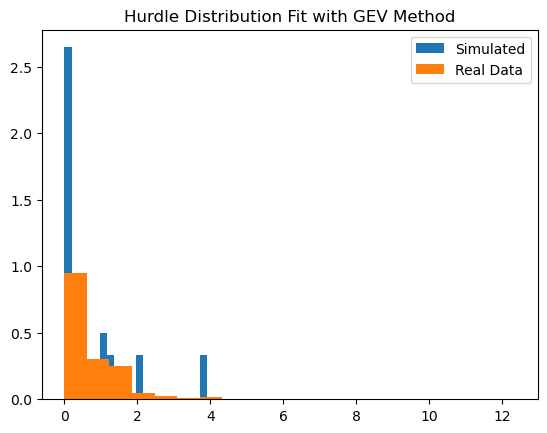

In [164]:
plt.hist(flood_hurdle_ls, density=True, bins = 20)
plt.hist(full_values, density = True, bins = 20)
plt.title("Hurdle Distribution Fit with GEV Method")
plt.legend(["Simulated","Real Data"])
plt.show()

# Truncated and Hurdle Distribution using Weibull

In [146]:
def weibull(data: np.ndarray):
    # if np.isnan(data).any():
    #     return (np.nan, np.nan)
    ranks = data.argsort().argsort()+1
    probs = ranks/(len(ranks)+1)
    slope, intercept = np.polyfit(probs, np.log10(data), 1)
    return slope, intercept


def truncated_weibull_fit(depth_data: np.ndarray, aep: float) -> float:
    """ Calculate the flood depth percentile for a given AEP. """
    pct = 1- aep
    # Calculate the portion of non-zero values 
    prob_zero = np.sum(depth_data == 0) / depth_data.size
    depth_nonzero = depth_data[depth_data != 0]
    slope, intercept = weibull(depth_nonzero) 
    if pct > prob_zero:
        pct_non_zero = (pct - prob_zero) / (1.0 - prob_zero) 
        non_zero_pct_depth = 10**(slope * pct_non_zero + intercept)
        return non_zero_pct_depth
    else:
        return 0

flood_truc_ls = []
for i in aep_sim:
    flood_simu = truncated_weibull_fit(full_values, i)
    flood_truc_ls.append(flood_simu)

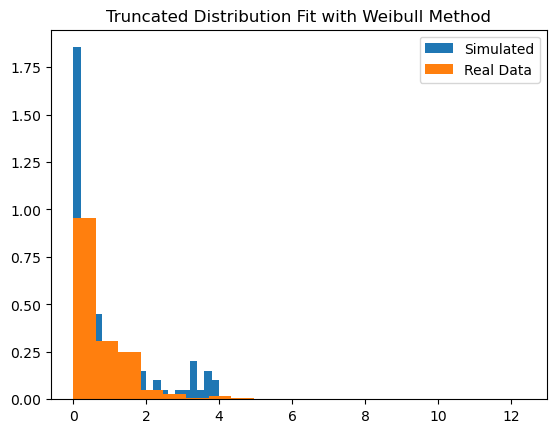

In [157]:
plt.hist(flood_truc_ls, density=True, bins = 20)
plt.hist(full_values, density = True, bins = 20)
plt.title("Truncated Distribution Fit with Weibull Method")
plt.legend(["Simulated","Real Data"])
plt.show()

In [148]:
def hurdle_weibull_fit(depth_data: np.ndarray, aep: float) -> float:
    """ Calculate the flood depth percentile for a given AEP. """
    pct = 1- aep
    # Calculate the portion of non-zero values 
    prob_zero = np.sum(depth_data == 0) / depth_data.size
    depth_nonzero = depth_data[depth_data != 0]
    slope, intercept = weibull(depth_nonzero)  
    if pct > prob_zero:
        pct_non_zero = 1 - aep / prob_zero
        non_zero_pct_depth = 10**(slope * pct_non_zero + intercept)
        return non_zero_pct_depth
    else:
        return 0

flood_hurdle_ls = []
for i in aep_sim:
    flood_simu = hurdle_weibull_fit(full_values, i)
    flood_hurdle_ls.append(flood_simu)

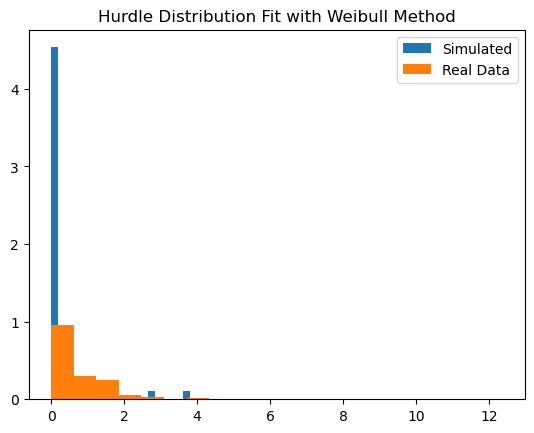

In [158]:
plt.hist(flood_hurdle_ls, density=True, bins = 20)
plt.hist(full_values, density = True, bins = 20)
plt.title("Hurdle Distribution Fit with Weibull Method")
plt.legend(["Simulated","Real Data"])
plt.show()